In [17]:
# Программа регрессионного анализа Лабораторного практикума

In [18]:
import pandas as pd # Вызов библиотек поанализу данных
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [19]:
df = pd.read_excel("CarData1Lab.xlsx") #читаем данные, файл должен находиться в одной папке с данным блокнотом
df.info() # инфо по столбцам, видим что есть столбцы в котором часть значений отсутствует

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        155 non-null    object 
 1   mpg         154 non-null    float64
 2   cylinders   155 non-null    int64  
 3   displace    155 non-null    int64  
 4   horsepower  151 non-null    float64
 5   accel       155 non-null    float64
 6   year        155 non-null    int64  
 7   weight      155 non-null    int64  
 8   origin      155 non-null    int64  
 9   make        155 non-null    object 
 10  model       154 non-null    object 
 11  price       155 non-null    int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 14.7+ KB


In [20]:
#df.isnull().sum() #количество пустых элементов в каждом из столбцов

In [21]:
df = df.dropna() #удаляем строки с пропусками
#df.info()
def out_color(text): # функции печати в цвете  
    print("\033[31m{}".format(text))
def black_color(text):
    print("\033[30m{}".format(text))

**Отбираем данные в соответсвии с вариантом**
Для составления сложных условий исп. операторы: | ИЛИ, & И, ~ НЕ, также необходимо  расставлять скобки
Например:
df[(df["origin"]==1) | (df["origin"]==2)]
либо воспользоваться языком запросов:
df.query('origin==1 | origin==2')

In [22]:
# Примеры запросов на формирование выборки
#data1=df[(df['origin']==1)] # в данном случае отбираются только автомобили со страной производства с кодом 1 (США)
data1 = df.query('displace >= 90 & displace <= 99')# выбрать авто США с 4-мя цилиндрами ценой < 8000
#data1 = df.query('origin == 1 | origin == 2') # выбрать авто США и Европы
print('Размерность выборки данных = ',data1.shape)
data = data1.copy()
data_col = data.columns #список имен стобцов
print('Cписок имен столбцов\n',list(data_col))

k=int(input('Введите число качественных переменных, преобразуемых в булеву шкалу = '))
if k != 0 :
    for m in range(k):
        lst=input('Введите имя переменной (без апострофов) => ')
        data = pd.get_dummies(data,drop_first=True,columns=[lst])# переводим категориальные признаки в численные, создавая новые столбцы с категориями, 0 - признак не относится к данной категории, 1 - относится. На каждый признак столбцов получается на 1 меньше чем категорий в нём ( параметр  drop_first )
#print(data.info()) 

data=data.select_dtypes(include=['float64', 'int64', 'uint8']) #оставляем только количесвенные переменные
num_columns = data.columns
print('Cписок имен столбцов с количественными переменными\n',list(num_columns))


Размерность выборки данных =  (24, 12)
Cписок имен столбцов
 ['name', 'mpg', 'cylinders', 'displace', 'horsepower', 'accel', 'year', 'weight', 'origin', 'make', 'model', 'price']
Cписок имен столбцов с количественными переменными
 ['mpg', 'cylinders', 'displace', 'horsepower', 'accel', 'year', 'weight', 'origin', 'price']


1 mpg          2 cylinders    3 displace     4 horsepower   5 accel        6 year         7 weight       8 origin       9 price        


<Axes: xlabel='displace', ylabel='price'>

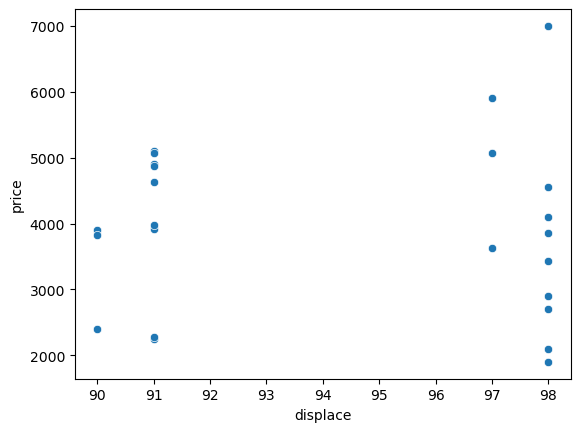

In [23]:
for i in np.arange(len(data.columns)): # формирование пронумерованного списка переменных
    a = str(i+1)+' '+data.columns[i]
    print('{0:15s}'.format(a),end='')
print()
# ВНИМАНИЕ! При вводе переменные не должны содержать пробелы до и после имени
y_name = input('\nВведите имя целевой (зависимой) переменной y => ') 
x_name = input('Введите имя предикторной переменной        x => ')

target=data[y_name] # целевой столбец
#target=data[data_col[i]] # целевой столбец

# Диаграммы рассеяния: парная
sns.scatterplot(data=data,y=y_name,x=x_name) 

# Диаграммы рассеяния: полная - все количественные переменные задействованы
# время счёта может составлять минуты
#sns.pairplot(data=data) 



In [24]:
data = data.drop([y_name],axis=1) # исключаем целевую переменую
print("\nЦелевой столбец target\n ", target)
print(data)


Целевой столбец target
  0      2400
1      1900
4      2250
22     2100
35     3425
51     2700
60     2275
65     7000
67     2900
73     5900
81     3900
82     3825
85     3925
87     3625
105    3975
107    3850
108    4100
133    4900
134    5100
136    4550
140    4625
141    4875
142    5075
151    5075
Name: price, dtype: int64
      mpg  cylinders  displace  horsepower  accel  year  weight  origin
0    43.1          4        90        48.0   21.5    78    1985       2
1    36.1          4        98        66.0   14.4    78    1800       1
4    36.1          4        91        60.0   16.4    78    1800       3
22   30.0          4        98        68.0   16.5    78    2155       1
35   29.5          4        98        68.0   16.6    78    2135       3
51   35.7          4        98        80.0   14.4    79    1915       1
60   37.3          4        91        69.0   14.7    79    2130       2
65   41.5          4        98        76.0   14.7    80    2144       2
67   32.1   

##### Парная регрессия

In [25]:

#print(x_name)
feature = data[x_name] # предикторная переменная
#feature = data['cylinders']# признак, по которому строим регрессию

if feature.std() == 0.0:
    out_color('\nВНИМАНИЕ !')
    print('Выбранная переменная имеет нулевую дисперсию,')
    print('     поэтому РЕГРЕССИЮ по ней ПОСТРОИТЬ НЕВОЗМОЖНО.')
    print('Выберите другую переменную.')
#print(feature)

__________________Linear regression______________________________

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                  0.002598
Date:                Tue, 19 Nov 2024   Prob (F-statistic):              0.960
Time:                        16:03:03   Log-Likelihood:                -205.46
No. Observations:                  24   AIC:                             414.9
Df Residuals:                      22   BIC:                             417.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

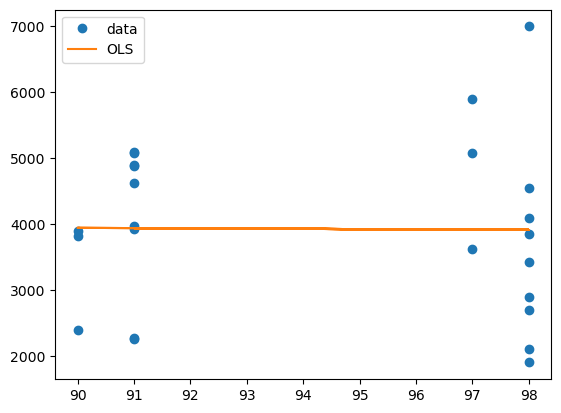

In [26]:
X1 = feature # предикторная переменная 
y1 = target  # целевая переменная 
                                    
# Активизируйте одну из двух нижеследующих команд
# X2 = X1 # эту команду следует активизировать для регрессии без свободного члена
X2 = sm.add_constant(X1) # Добавление столбца из единиц в матрицу Х
# print('Таблица значений предикторных переменных (<= 20 значений),\n',  X2.head(20))

est = sm.OLS(y1, X2) # вызов МНК
est2 = est.fit()     # оценивание
print ("__________________Linear regression______________________________")
#print('Переменная х\n',X1.head()); print('Переменная y\n',y1.head())

print(); print(est2.summary())

N = est2.nobs  #число объектов - наблюдений
k = est2.df_model+1 #число степеней свободы
dfm, dfe = k-1, N - k
SSR = est2.ssr # остаточная сумма квадратов, посчитанная внутри модуля
sterror = (SSR/dfe)**0.5

print('\n==========================================================')
print("Сумма квадратов остатков SSR = ",round(est2.ssr))
print("Стандартная ошибка                      = ",round(sterror,2))
print('==========================================================')

y_fitted = est2.fittedvalues #y,оцененный по уравнению регрессии
#print(y1.dtype,y_fitted.dtype)
#print('\nY наблюденное',y1)
#print('\nY оцененное ',y_fitted)

plt.plot(X1, y1, 'o', label='data')
plt.plot(X1, y_fitted,label='OLS')
plt.legend(loc='best')





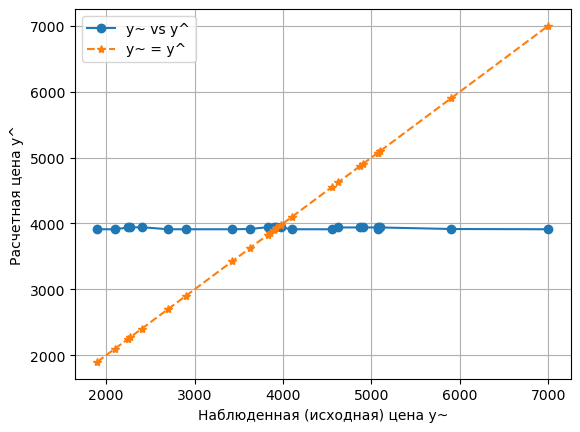

In [27]:
y1a = pd.DataFrame(target)              # формирование dataframe
#print(y1a,y_fitted)
y_fitteda = pd.DataFrame(y_fitted)       # из исходного у и
#print('y_fitteda\n',y_fitteda)
yout = pd.concat([y1a,y_fitteda],axis=1)  # оцененного у
#print('yout\n',yout)
yout_sort = yout.sort_values(by=y_name)# упорядочение по исходному у
#print('yout_sort\n',yout_sort)
yout_sortV = yout_sort.values # перевод dataframe в двумерный массив
#print('yout_sortV\n',yout_sortV)
xprice = yout_sortV[:,0] # первая колонка - будущие иксы
yprice = yout_sortV[:,1] # вторая колонка - будущие игреки
#print('xprice\n',xprice,'yprice\n ',yprice)

plt.plot(xprice,yprice,'o-',label='y~ vs y^')
plt.plot(xprice,xprice,'--*',label='y~ = y^')
plt.grid(True)
plt.xlabel('Наблюденная (исходная) цена y~')
plt.ylabel('Расчетная цена y^')
plt.legend(loc='best') 

In [28]:
X1 = feature
y1 = np.log(target) # для экспоненциальной регрессии, берём логарифм от y, => часть с коэффициентами принимает обычный линейный вид

X2 = sm.add_constant(X1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print ("____________________Exp regression________________________________")
print('Переменная х ...',X1.head(0))
print('Зависимая переменная log(y) ...',y1.head(0))
print(); print(est2.summary())

____________________Exp regression________________________________
Переменная х ... Series([], Name: displace, dtype: int64)
Зависимая переменная log(y) ... Series([], Name: price, dtype: float64)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                   0.06500
Date:                Tue, 19 Nov 2024   Prob (F-statistic):              0.801
Time:                        16:03:03   Log-Likelihood:                -8.2379
No. Observations:                  24   AIC:                             20.48
Df Residuals:                      22   BIC:                             22.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

In [29]:
X1 = feature
y1 = 1/target # для обратной регрессии

X2 = sm.add_constant(X1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print ("______________________Reciprocal regression______________________")
print('Переменная х... ',X1.head(0)) 
print('Зависимая переменная 1/y... )',y1.head(0),)
print(est2.summary())


______________________Reciprocal regression______________________
Переменная х...  Series([], Name: displace, dtype: int64)
Зависимая переменная 1/y... ) Series([], Name: price, dtype: float64)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.1629
Date:                Tue, 19 Nov 2024   Prob (F-statistic):              0.690
Time:                        16:03:03   Log-Likelihood:                 186.26
No. Observations:                  24   AIC:                            -368.5
Df Residuals:                      22   BIC:                            -366.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

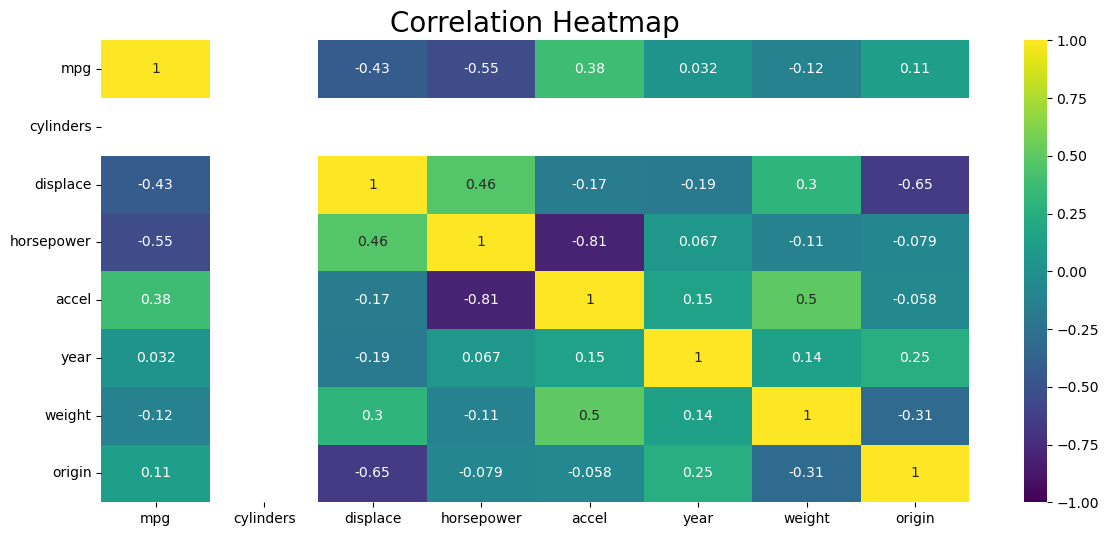

In [30]:
plt.figure(figsize=(14, 6))


mask = np.triu(np.ones_like(data.corr(), dtype= bool))# Определите маску, чтобы установить значения в верхнем треугольнике на True, чтобы выводилась только половина матрицы
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap = "viridis")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20});

#### Множественная регрессия

In [36]:
y_name = 'price'  # например, определите y_name здесь

# Проверьте, существует ли y_name в DataFrame
if y_name in data.columns:
    data = data.drop([y_name], axis=1)
else:
    print(f"Столбец '{y_name}' не найден в DataFrame.")

numFeatures = list(data.columns)
print('Список имён предикторных количественных переменных\n', numFeatures)

vectorVariance = data.std()
print('Дисперсия переменных\n', vectorVariance)

categFeatures = ["origin",]  # список имён категориальных признаков

# К этой строке в коде был небольшой момент, kоторый был не совсем корректен
# Изменено на data[categFeatures] для охвата всех категориальных признаков
encCatData = pd.get_dummies(data[categFeatures], drop_first=True)

Столбец 'price' не найден в DataFrame.
Список имён предикторных количественных переменных
 ['mpg', 'cylinders', 'displace', 'horsepower', 'accel', 'year', 'weight', 'origin']
Дисперсия переменных
 mpg             4.811392
cylinders       0.000000
displace        3.602535
horsepower      8.606957
accel           2.994052
year            1.503016
weight        145.183143
origin          0.850192
dtype: float64


In [37]:
allFeaturesData = numFeaturesData.join(encCatData)# снова собираем датафрейм со всеми признаками
allFeatures = list(allFeaturesData.columns)
print(allFeatures)

NameError: name 'numFeaturesData' is not defined

Таблица данных 
      mpg  cylinders  displace  horsepower  accel  year  weight  origin
0   43.1          4        90        48.0   21.5    78    1985       2
1   36.1          4        98        66.0   14.4    78    1800       1
4   36.1          4        91        60.0   16.4    78    1800       3
22  30.0          4        98        68.0   16.5    78    2155       1
35  29.5          4        98        68.0   16.6    78    2135       3 
 Дисперсии переменных
 mpg             4.811392
cylinders       0.000000
displace        3.602535
horsepower      8.606957
accel           2.994052
year            1.503016
weight        145.183143
origin          0.850192
dtype: float64

Число столбцов с нулевой дисперсией =  1.0

ВНИМАНИЕ!
    Столбец с именем " cylinders " есть константа.  Он будет исключён!


Linear regression
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.776
Model:        

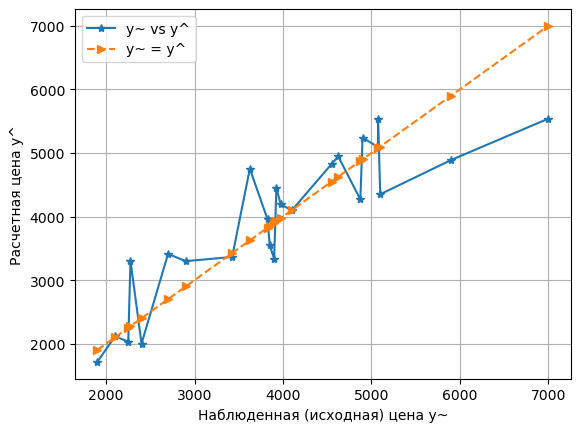

In [38]:
# Функция множественной линейной регрессии
# параметр features - список имен предикторных переменных
def mulRegression(features):
    X1 = data[features]
    y1 = target
    #print(y1.index)
    #print(X1.index)
    
    vectorVariance = X1.std() #'Здесь хранятся дисперсии переменных'
    
    print('Таблица данных \n',X1.head(),'\n', 
          'Дисперсии переменных\n',vectorVariance)
    # Проверка: нет ли в данных столбца с одинаковыми значениями
    m = len(features) # m - число столбцов в таблице данных
    s = np.zeros(m)
    #print(s)
    for j in range(m): # поиск переменных (столбцов) с нулевой дисперсией
        if vectorVariance.iloc[j] == 0.:
            s[j] = 1
            #print(s)
    print('\nЧисло столбцов с нулевой дисперсией = ',s.sum())
    
    

    if s.sum() != 0:
        for j in range(m):
            if s[j] != 0:
                out_color("\nВНИМАНИЕ!")
                print('    Столбец с именем "',features[j],'" есть константа.  Он будет исключён!\n')
                X1 = X1.drop([features[j]],axis=1)
                
    black_color('')
                
    # Активизируйте одну из двух нижеследующих команд
    #X2 = X1 # эту комаду следует активизировать для регрессии без свободного члена
    X2 = sm.add_constant(X1) # Добавление столбца из единиц в матрицу Х
    #print('X2\n',X2)
    est = sm.OLS(y1, X2)
    est2 = est.fit()
    print("Linear regression")
    print(est2.summary())
    N = est2.nobs  #число объектов - наблюдений
    k = est2.df_model+1 #число степеней свободы
    dfm, dfe = k-1, N - k
    SSR = est2.ssr # остаточная сумма квадратов, посчитанная внутри модуля
    sterror = (SSR/dfe)**0.5

    print('\n==========================================================')
    print("Количество N наблюдений (объектов)      = ",round(N))
    print("Число членов в уравнении регрессии k+1  = ",round(k))
    print("Сумма квадратов остатков SSR = ",round(SSR))
    print("Стандартная ошибка                      = ",round(sterror,2))
    print('==========================================================')
    
    y_fitted = est2.fittedvalues
    #print('y_fitted\n',y_fitted)
    
    y1a = pd.DataFrame(target)              # формирование dataframe
    y_fitteda = pd.DataFrame(y_fitted)      # из исходного у и
    yout = pd.concat([y1,y_fitteda],axis=1)  # оцененного у
    #print('yout\n',yout)
    yout_sort = yout.sort_values(by=y_name)# упорядочение по исходному у
    yout_sortV = yout_sort.values # перевод dataframe в двумерный массив
    xprice = yout_sortV[:,0] # первая колонка - будущие иксы
    yprice = yout_sortV[:,1] # вторая колонка - будущие игреки
    
    plt.plot(xprice,yprice,'*-',label='y~ vs y^')
    plt.plot(xprice,xprice,'>--',label='y~ = y^')
    plt.grid(True)
    plt.xlabel('Наблюденная (исходная) цена y~')
    plt.ylabel('Расчетная цена y^')
    plt.legend()   

# Запуск программы с полным перечнем переменных    
mulRegression(numFeatures)


1 mpg              2 cylinders        3 horsepower       4 accel            5 year             6 weight           7 origin           ['mpg', 'cylinders', 'horsepower', 'year', 'weight', 'origin']
Таблица данных 
      mpg  cylinders  horsepower  year  weight  origin
0   43.1          4        48.0    78    1985       2
1   36.1          4        66.0    78    1800       1
4   36.1          4        60.0    78    1800       3
22  30.0          4        68.0    78    2155       1
35  29.5          4        68.0    78    2135       3 
 Дисперсии переменных
 mpg             4.811392
cylinders       0.000000
horsepower      8.606957
year            1.503016
weight        145.183143
origin          0.850192
dtype: float64

Число столбцов с нулевой дисперсией =  1.0

ВНИМАНИЕ!
    Столбец с именем " cylinders " есть константа.  Он будет исключён!


Linear regression
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared

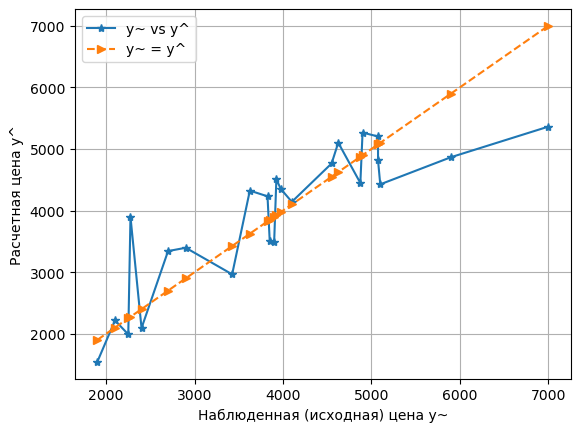

In [40]:
# Эту ячейку необходимо запускать по мере исключения предикторных переменных
#     до тех пор, пока не останутся лишь значимые переменные

#print('numFeatures ',numFeatures)
for i in np.arange(len(numFeatures)):
    a = str(i+1)+' '+ numFeatures[i]
    print('{0:19s}'.format(a),end='')

nomer_x = int(input('\nВведите номер исключаемой предикторной переменной = ')) 
nn = nomer_x-1
#print('nn = ',nn)
del numFeatures[nn] # Удаление имени исключаемой переменной
print(numFeatures)

mulRegression(numFeatures) # Обращение к функции многомерной регрессии


#### Тест чоу

data Чоу1
      mpg  cylinders  horsepower  year  weight  origin
0   43.1          4        48.0    78    1985       2
1   36.1          4        66.0    78    1800       1
4   36.1          4        60.0    78    1800       3
22  30.0          4        68.0    78    2155       1
35  29.5          4        68.0    78    2135       3
Таблица данных 
      mpg  cylinders  horsepower  year  weight  origin
0   43.1          4        48.0    78    1985       2
1   36.1          4        66.0    78    1800       1
4   36.1          4        60.0    78    1800       3
22  30.0          4        68.0    78    2155       1
35  29.5          4        68.0    78    2135       3 
 Дисперсии переменных
 mpg             4.811392
cylinders       0.000000
horsepower      8.606957
year            1.503016
weight        145.183143
origin          0.850192
dtype: float64

Число столбцов с нулевой дисперсией =  1.0

ВНИМАНИЕ!
    Столбец с именем " cylinders " есть константа.  Он будет исключён!


Linear 

c:\Users\lavro\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)


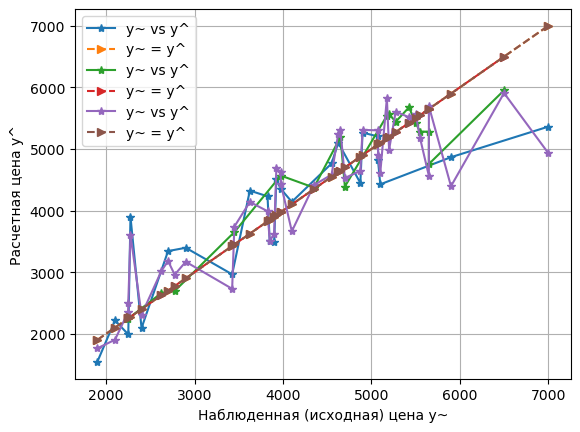

In [41]:

#           СТРОИМ РЕГРЕССИЮ ДЛЯ ПЕРВОЙ ВЫБОРКИ
# в данном случае отбираются только автомобили со страной производства 3
#print(data1)
#print(numFeatures)
data1 = df.query('displace >= 90  & displace <= 99')
data = data1[numFeatures]
print('data Чоу1\n',data.head())
target = data1[y_name] # целевой столбец
mulRegression(numFeatures) 

# СТРОИМ РЕГРЕССИЮ ДЛЯ ВТОРОЙ ВЫБОРКИ
data1 = df.query('displace >= 100  & displace <= 112')
data = data1[numFeatures]
print('data Чоу2 \n',data.head())
target = data1[y_name] # целевой столбец
mulRegression(numFeatures) # Обращение к функции регрессионнлго анализа

#           СТРОИМ РЕГРЕССИЮ ДЛЯ ОБЪЕДИНЕННОЙ ВЫБОРКИ
data1 = df.query('(displace >= 90 & displace <= 99) | (displace >= 100 & displace <= 112)')
data = data1[numFeatures]
print('data Чоу_1_2 \n',data.head())
target = data1[y_name] # целевой столбец

mulRegression(numFeatures) # Обращение к функции регрессионного анализа



